In [1]:
#!/usr/bin/python
import sys
sys.path.insert(0, '../Newby-tools/utilities')
import astro_coordinates as ac
import numpy as np
import math as ma
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import scipy as sc

deg = 180.0 / ma.pi
rad = ma.pi / 180.0 
lCP = 122.932 * rad #123.932 is the wrong value in B&M
surveyCenterRa = 185.0
surveyCenterDec = 32.5
raGP = 192.8594813 * rad
decGP = 27.1282511 * rad
arr = sc.array([0.0])
dsun = 8.5  # 8.0 is current IAU standard!

def checkGlobularClusters():
    clusters = [ [], [], [], [] ]
    
    f = open("/home/weissj3/Desktop/HarrisCatalog.txt", 'r')
    #File Format 46-51 and 53-58
    
    for line in f:
        if line[46:51] != "     " and  line[53:58] != "     " and line[60:64] != "    ":
            templ, tempb, tempr = float(line[46:51]), float(line[53:58]), float(line[60:64])
            
            if templ > 40 and templ < 210 and tempb < -30 and tempb > -80:
                clusters[0].append(templ)
                clusters[1].append(tempb)
                clusters[2].append(getg(tempr))
                clusters[3].append(line[1:9])
                print(line[1:9], templ, tempb, tempr)
                
        
    return clusters

def getg (r, M=4.2):
    #"""converts a distance (kpc) into a magnitude"""
    return M + 5.*(sc.log10(r*1000) - 1.)

def readStarFile_lb(x):
    f = open(x, 'r');
    f.readline()
    stars2 = np.array([ list(map(float, ln.replace(',', '').split())) for ln in f ])
    return stars2[:,0].tolist(), stars2[:,1].tolist(), stars2[:,2].tolist()

def lb2GC(l, b, wedge):
    ra, dec = lbToEq(l, b)
    return EqToGC(ra, dec, wedge)
    
def lbToEq (l_deg, b_deg):   
    #""" Converts galactic l,b in to Equatorial ra, dec; from Binney and Merrifield, p. 31;  
    #l, b must be arrays of same shape"""
    l, b = (l_deg*rad), (b_deg*rad)
    # Conversion Code
    t = lCP - l
    dec = sc.arcsin(sc.sin(decGP)*sc.sin(b) + sc.cos(decGP)*sc.cos(b)*sc.cos(t) )
    r = sc.arctan2( (sc.cos(b)*sc.sin(t)),
                    ( (sc.cos(decGP)*sc.sin(b)) - (sc.sin(decGP)*sc.cos(b)*sc.cos(t)))  )
    if type(r) != type(arr):  r = sc.array([r])
    for i in range(len(r)):
        r[i] = angle_bounds((r[i] + raGP)*deg)
    return r, (dec*deg)

def angle_bounds (angle, min=0.0, max=360.0):
    #""" Keeps an angle, in degrees, in a 360 degree region"""
    while angle < min:  angle = angle + 360.0
    while angle > max:  angle = angle - 360.0
    return angle

def angle_bounds2 (theta, phi):
    #""" Sets two spherical angles in bounds, -90<theta<90; 0<phi<360"""
    if type(theta) != type(arr):  theta = sc.array([theta])
    if type(phi) != type(arr):  phi = sc.array([phi])
    for i in range(len(theta)):
        theta[i] = angle_bounds(theta[i], -180.0, 180.0)
    for i in range(len(theta)):
        if sc.fabs(theta[i]) > 90.0:
            theta[i] = 180.0 - theta[i]
            phi[i] = phi[i] + 180.0
    for i in range(len(theta)):
        theta[i] = angle_bounds(theta[i], -180.0, 180.0)
        phi[i] = angle_bounds(phi[i], 0.0, 360.0)
    for i in range(len(theta)):
        if (sc.fabs(theta[i]) == 90.0):  phi[i] = 0.0
    if len(theta)==1:
        theta, phi = theta[0], phi[0]
    return theta, phi

def get_eta (wedge):
    #""" Get the eta value that corresponds to the given stripe value """  #wedge_eta?
    ss = 2.5
    if wedge <= 46:  eta = wedge * ss - 57.5
    else:  eta = wedge * ss - 57.5 - 180.0
    return eta

def EqToGC (ra_deg, dec_deg, wedge):  #produces lists...  anglebounds2!!!  ROTATE
    #""" Converts equatorial ra,dec into Great Circle mu, nu; 'atSurveyGeometry.c' in
    #m31.phys.rpi.edu:/p/prd/astrotools/v5_18/Linux-2-4-2-3-2/src"""
    node = (surveyCenterRa - 90.0)*rad
    eta = get_eta(wedge)
    inc = (surveyCenterDec + eta)*rad
    ra, dec = (ra_deg*rad), (dec_deg*rad)
    # Rotation
    x1 = sc.cos(ra-node)*sc.cos(dec)
    y1 = sc.sin(ra-node)*sc.cos(dec)
    z1 = sc.sin(dec)
    x2 = x1
    y2 = y1*sc.cos(inc) + z1*sc.sin(inc)
    z2 = -y1*sc.sin(inc) + z1*sc.cos(inc)
    mu = sc.arctan2(y2,x2) + node
    nu = sc.arcsin(z2)
    nu, mu = angle_bounds2((nu*deg), (mu*deg))
    return mu,nu


def makeArrows(data, coord = 'dec'):
    sgrArrow = {'ra' : [], 'dec' : [], 'r' : [], 'norm' : []}

    for k in range(len(data['mu'])):
        tmpra, tmpdec, tmpr = ac.streamToEqR(0.0,0.0,1.0,data['mu'][k], data['r'][k], data['theta'][k]*ac.deg, data['phi'][k]*ac.deg, data['wedge'][k])
        sgrArrow['ra'].append(tmpra[0] - data['ra'][k])
        sgrArrow['dec'].append(tmpdec  - data['dec'][k])
        sgrArrow['r'].append(tmpr - data['r'][k])
        sgrArrow['norm'].append(ma.sqrt(sgrArrow['ra'][k]**2. + sgrArrow['dec'][k]**2. + sgrArrow['r'][k]**2.))

    for k in range(len(data[coord])):
        plt.arrow(data['ra'][k], data[coord][k], 2*sgrArrow['ra'][k]/sgrArrow['norm'][k], 2*sgrArrow[coord][k]/sgrArrow['norm'][k], length_includes_head=True, head_width=.1, head_length=.4)

In [2]:
stars = [ [], [], [] ]
for i in range(80, 87):
    #temp1, temp2, temp3 = readStarFile_lb("/home/weissj3/Desktop/SDSSSouth/DR_14_Stripe_%d_Rev_4.stars" % i)
    #temp1, temp2, temp3 = readStarFile_lb("/home/weissj3/Desktop/SDSSSouth/stars-%d.txt" % i)
    temp1, temp2, temp3 = readStarFile_lb("/home/weissj3/Desktop/SDSSSouth/stars-%d_2.txt" % i)
    #temp = np.where((np.array(stars[2]) < 20.0) & (np.array(stars[2]) > 10.0))# and (stars[2] > 24.0))
    temp = np.where((np.array(temp2) < -30.0))# and (stars[2] > 24.0))
    temp1 = list(np.array(temp1)[temp])
    temp2 = list(np.array(temp2)[temp])
    temp3 = list(np.array(temp3)[temp])
    
    stars[0] = stars[0] + temp1
    stars[1] = stars[1] + temp2
    stars[2] = stars[2] + temp3
    
clusters = checkGlobularClusters()

NGC 7089 53.3 -35.7 11.0
Pal 13   87.1 -42.7 26.0
NGC 7492 53.3 -63.4 25.0


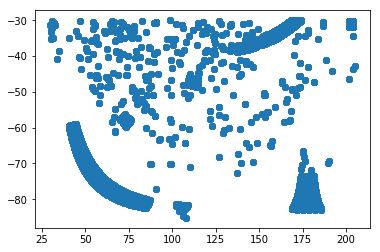

In [3]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import ascii

Mask = dict()
Mask["Hole"] = ascii.read("../Data/SDSSSkyHoleMask.csv")
Mask["Bright"] = ascii.read("../Data/SDSSSkyBrightMask.csv")
Mask["Bleed"] = ascii.read("../Data/SDSSSkyBleedMask.csv")
Mask["Trail"] = ascii.read("../Data/SDSSSkyTrailMask.csv")
c_low = dict()
for i in Mask:
    c = SkyCoord(Mask[i]["ra"], Mask[i]["dec"], frame='icrs', unit='deg').transform_to('galactic')
    c_mask = c.b < (-30 * u.deg)
    c_low[i] = c[c_mask]
plt.plot(c_low["Hole"].l, c_low["Hole"].b, 'o')
plt.show()

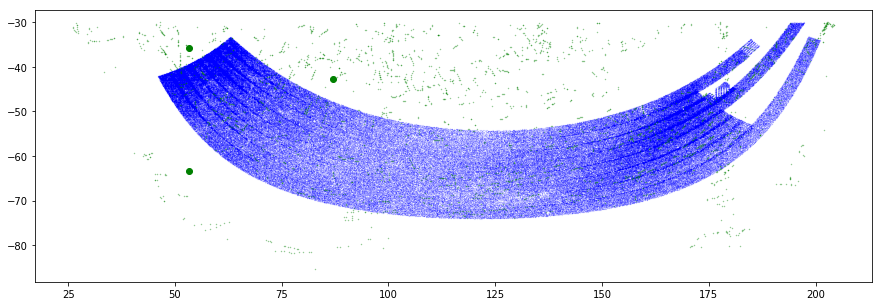

In [4]:
plt.figure(1,figsize=(15,5))
plt.plot(stars[0], stars[1], "bo", ms=.05, alpha=.5)
plt.plot(clusters[0], clusters[1], "go")
plt.plot(c_low["Trail"].l, c_low["Trail"].b, 'go',  ms=.4, alpha=.5)
plt.show()

80Mu lims
365.00904349689444 394.99825067900383
g Lim
16.000429677206473 22.494690015990244
Nu Lim
-1.2498417962917987 1.2498568201979143
81Mu lims
350.0028611818422 399.9985844308177
g Lim
16.005169606818125 22.49473001890145
Nu Lim
-1.249866475045871 1.249694617733565
82Mu lims
350.0033948988235 399.999838993014
g Lim
16.000510229748585 22.494740019514108
Nu Lim
-1.2499332711105824 1.249986409977621
83Mu lims
350.0021669023405 399.99373123587515
g Lim
16.000180419236177 22.49481002251313
Nu Lim
-1.2499918791461413 1.2499510406310543
84Mu lims
350.0017314256981 399.9947700165113
g Lim
16.001070224233526 22.49481002251313
Nu Lim
-1.2499987839771416 1.2499848744681277
85Mu lims
350.0005513705528 399.9980310799885
g Lim
16.000989692462575 22.49481002251313
Nu Lim
-1.2499353675682494 1.2498851560094035
86Mu lims
350.0005179567989 399.99957294019623
g Lim
16.00053960699092 22.49467001425829
Nu Lim
-1.249978531773556 1.2499900030658153


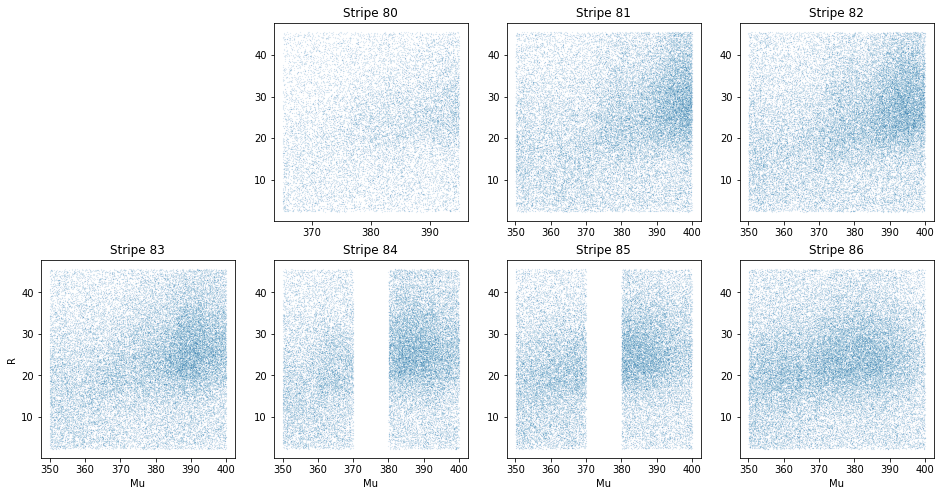

In [61]:

plt.figure(1, figsize=(16, 8))

for i in range(80, 87):
    plt.subplot(2,4,i-78)
    temp1, temp2, temp3 = readStarFile_lb("/home/weissj3/Desktop/SDSSSouth/stars-%d_2.txt" % i)
    temp = np.where((np.array(temp2) < -30.0))# and (stars[2] > 24.0))
    temp1 = list(np.array(temp1)[temp])
    temp2 = list(np.array(temp2)[temp])
    temp3 = list(np.array(temp3)[temp])
    temp1, temp2 = lb2GC(np.array(temp1), np.array(temp2), i)
    for j in range(len(temp1)):
        if temp1[j] < 150:
            temp1[j] = temp1[j] + 360.0
    plt.plot(temp1, temp3, 'o', ms=0.1, alpha=0.5)
    print(str(i) + "Mu lims")
    print(min(temp1), max(temp1))
    print("g Lim")
    print(getg(min(temp3)), getg(max(temp3)))
    print("Nu Lim")
    print(min(temp2), max(temp2))
    plt.title("Stripe %d" % i)
    if i - 78 > 4:
        plt.xlabel("Mu")
    if (i - 78) == 1 or (i - 78) == 5:
        plt.ylabel("R")
    
plt.show()
    

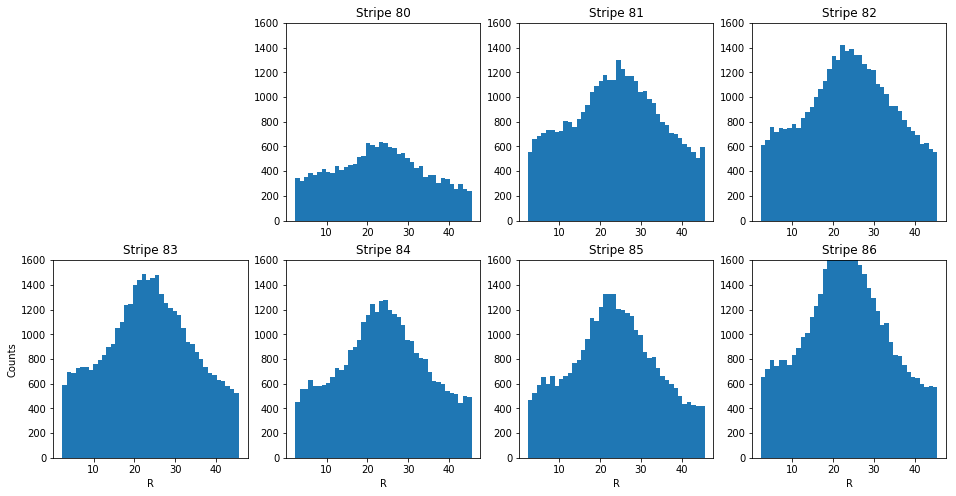

In [59]:
plt.figure(1, figsize=(16, 8))

for i in range(80, 87):
    plt.subplot(2,4,i-78)
    temp1, temp2, temp3 = readStarFile_lb("/home/weissj3/Desktop/SDSSSouth/stars-%d_2.txt" % i)
    temp = np.where((np.array(temp2) < -30.0))# and (stars[2] > 24.0))
    temp1 = list(np.array(temp1)[temp])
    temp2 = list(np.array(temp2)[temp])
    temp3 = list(np.array(temp3)[temp])
    temp1, temp2 = lb2GC(np.array(temp1), np.array(temp2), i)
    for j in range(len(temp1)):
        if temp1[j] < 150:
            temp1[j] = temp1[j] + 360.0
    plt.hist(temp3, bins=40)
    plt.title("Stripe %d" % i)
    plt.ylim(0, 1600)
    if i - 78 > 4:
        plt.xlabel("R")
    if (i - 78) == 1 or (i - 78) == 5:
        plt.ylabel("Counts")
    
plt.show()

In [4]:




fitParameters1 = [[0.99610854796299, 0.602707695537048, -1.91409127023908, 394.999536157082, 26.3034791728196, 2.70612761879803, 2.85144592613987, 1.3969235362309, -0.23656017282301, 385.32961593779, 23.8400908073428, 0.4521374080478, 1.01738245820873, 3.79651317783094, -1.89765799828133, 365.013719108822, 45.3828724029551, 1.41743008998293, 0.675894712848845, 3.30838010526825],

[0.999944612079743, 0.305901485053103, -1.61861075316423, 397.112028958749, 26.9669879667783, 1.78816018208519, 0.237181579753778, 0.698941446484881, -0.15027266337857, 377.224029474032, 35.0499388278361, 1.09124117905718, 0.325627431055257, 24.9992751352876, 0.412951991703798, 392.385461143937, 24.1080968204511, 0.827109082148601, 0.537533461647184, 4.86748749793852],

[0.98991378963277, 0.308289981214212, -1.54382724939751, 363.312100226944, 39.8615768517978, 0.928860509563496, 0.0736519965323057, 16.7270141001641, -0.5446031371613, 399.869256268919, 24.8882388994142, 0.635058202623914, 1.81890872116164, 6.22180674708641, -4.56421789620042, 391.056876195451, 7.99796529512058, 0.73136614238237, 2.86445727474234, 22.5991697823511],

[0.99994759953964, 0.252833477693611, 0.183960129525568, 340.141570004638, 12.4598340724202, 1.67456004755789, 1.30164830039372, 6.84689873624907, -0.401329375713388, 362.457389587379, 40.9237849950465, 1.29500975831299, 0.41331563896243, 10.6841892946136, 0.632459559003521, 389.959052282875, 24.3200903237175, 1.72972116118681, 2.8132762718471, 4.18107368079411],

[0.999606274155892, 0.283807028588464, 0.884551229674617, 384.758080221005, 22.9512072305092, 1.74559499366151, 2.70674029862282, 5.05004302665926, -0.52962588812335, 399.92689633255, 67.0978032693911, 1.24931282938646, 0.608042133517162, 15.4413182362025, -0.0523015479247553, 340.000714861477, 2.15252890832674, 2.37347256036285, 0.557351411140675, 5.56553078066461],

[0.997768949410222, 0.506205313961172, -0.424565531941287, 340.008064867463, 26.7863877685715, 1.80776977585074, 0.382493321582206, 24.9966498350949, -1.72119765195003, 382.728981125017, 26.6522293241025, 2.58627633073296, 0.62934242535028, 1.05417274142966, -0.168595254298105, 374.119447132412, 20.1852846232421, 1.89900401819141, 3.13997610064033, 3.2405824698739],

[0.998890926635154, 0.396327451595263, 0.472434509625133, 378.937922438113, 21.7590460985581, 1.81776806778579, 2.68056020974052, 4.78316538013624, -0.833958369362128, 344.432868891238, 16.6107690999911, 0.376441773644166, 2.84831751984169, 3.84391483141543, -0.978129743249635, 340.205371874273, 57.8836148531743, 1.04479216936567, 0.573387147455888, 21.2988225130648]]


fitParameters2 = [[0.99610854796299, 0.602707695537048, -1.91409127023908, 394.999536157082, 26.3034791728196, 2.70612761879803, 2.85144592613987, 1.3969235362309, -0.23656017282301, 385.32961593779, 23.8400908073428, 0.4521374080478, 1.01738245820873, 3.79651317783094, -1.89765799828133, 365.013719108822, 45.3828724029551, 1.41743008998293, 0.675894712848845, 3.30838010526825],

[0.999944612079743, 0.305901485053103, -1.61861075316423, 397.112028958749, 26.9669879667783, 1.78816018208519, 0.237181579753778, 0.698941446484881, -0.15027266337857, 377.224029474032, 35.0499388278361, 1.09124117905718, 0.325627431055257, 24.9992751352876, 0.412951991703798, 392.385461143937, 24.1080968204511, 0.827109082148601, 0.537533461647184, 4.86748749793852],

[0.98991378963277, 0.308289981214212, -1.54382724939751, 363.312100226944, 39.8615768517978, 0.928860509563496, 0.0736519965323057, 16.7270141001641, -0.5446031371613, 399.869256268919, 24.8882388994142, 0.635058202623914, 1.81890872116164, 6.22180674708641, -4.56421789620042, 391.056876195451, 7.99796529512058, 0.73136614238237, 2.86445727474234, 22.5991697823511],

[0.998987323136938, 0.399050910665437, 0.160352087877833, 389.946913598263, 24.1432145244422, 1.87971085349746, 2.73409216518943, 3.27612599559949, -1.39683172931462, 361.173423437739, 17.528164898432, 2.07955045269943, 2.96075250533922, 1.69063785469458, 0.0589742197941533, 342.69596464475, 7.51666716137765, 0.432048000737237, 1.50664386764998, 24.9800892354487],

[0.999514143424022, 0.353010401452215, 0.345662787792187, 381.999640275776, 20.0865675000566, 1.8134836984478, 3.0356899482246, 4.15523014899792, -0.0448448503061422, 371.21612396881, 23.1745805541976, 2.56212985803758, 3.11145585661537, 23.3620558185153, -1.10907661132703, 385.774159178775, 27.7194514033218, 1.98835636520523, 0.166167671132839, 1.16138123544008], 

[0.995097444283973, 0.626000840172645, 0.0712583308678124, 379.809738490696, 21.9121177553649, 1.81056271962407, 3.07572584462064, 3.02066075610657, -0.61887384339906, 359.874855327571, 15.5440871900317, 0.117878549612655, 1.32850310213516, 22.5959567022648, -3.85759422268846, 375.865412697147, 38.3064561785442, 0.421019604237409, 1.95632882456585, 0.364013294273391],               
                 
[0.998183412523476, 0.457395699018659, 0.507670102346122, 370.602333969371, 20.6493988313167, 1.88615579566336, 3.01167930655481, 4.35605908236623, -1.42742583581331, 385.890558902677, 20.4298908505314, 2.40780188791984, 1.9734032284167, 2.5513704955223, -1.16874100748135, 340.553852485396, 58.2255632124484, 1.03132161228673, 0.651317168151068, 19.7764228716911]]


fitParameters3 = [[0.996095386703113, 0.605001031132655, -1.90867997770891, 394.999624853765, 26.2956796698311, 2.70629603191247, 2.85375574489419, 1.40557088976001, -0.245553013771796, 385.310239076231, 23.8637854427311, 0.452894684636953, 1.01987648564684, 3.77764797025863, -1.90067027943739, 365.000400295218, 45.3471330899885, 1.41672345800552, 0.672696994212636, 3.29006036617721],

[0.999951130095193, 0.305165118614543, -1.61378626463984, 397.112391047192, 26.9347411275222, 1.79015028501204, 0.236974483076456, 0.702844383156497, -0.154012143013616, 375.840989686607, 34.7314737865858, 1.08775105785089, 0.327569911556916, 24.9997110189294, 0.417685793413689, 392.376143653667, 24.1006939740032, 0.8274236373312, 0.536814010827023, 4.88034333866563],

[0.846555745781395, 0.790380509055903, -5.17996067618991, 387.807028417306, 15.95870989728, 1.46897325669178, 0.069160216460613, 24.9932856003895, 0.577422346514052, 385.892483310183, 13.3069833739702, 1.58376181881735, 0.141754250270242, 12.2790961349676, -19.4296913478923, 364.747947063314, 25.6909183030174, 0.9403193032736, 2.15975688527402, 14.0433921187519],

[0.999029356688536, 0.383840271331872, 0.130183268405867, 389.805760603399, 23.7541851809112, 1.95821950004015, 2.69738983686784, 3.19801153908054, -1.37866506975388, 362.107020910335, 16.6134319586921, 2.31040583305856, 2.81773473680863, 1.42493642714004, 0.116381361979745, 341.20236891741, 16.2268319184901, 1.21823153126641, 0.685123549740093, 24.9837910020074],

[0.999800194340343, 0.334962313647555, 0.622319432858762, 380.677890436866, 19.5298151437474, 1.81730923950192, 3.04532059681204, 5.00166648166365, -0.548293668133295, 389.658079003318, 57.3154200494075, 1.8605397022772, 3.13779558280642, 16.1058303195384, -0.934529008929498, 386.032415417187, 26.8631038156831, 2.29421309956689, 0.242887786111848, 1.17249864263308], 

[0.99842125712376, 0.474774298457195, 0.396656287558022, 378.669650122223, 21.5214993556756, 1.89058480824441, 2.99418786486041, 3.81046355341051, -0.780658119246408, 350.608981864895, 33.9522112644126, 0.494852206212484, 0.708962223817862, 21.184934019546, -3.57189459285342, 375.865412697147, 38.3064561785442, 0.237661202204182, 1.72028883220076, 0.364013294273391],               
                 
[0.998032567082096, 0.452606223744073, 0.59204622137494, 365.110585189706, 20.0326761864454, 1.93733878046814, 3.01267466890258, 5.14103895594415, -1.03217199169312, 384.906930054461, 21.1299954312033, 2.24393848950451, 2.13143250949323, 2.95499645480943, -1.86517870948919, 340.202832068064, 47.8427274522105, 1.26638167777786, 0.465023993511414, 1.03218137119504]]






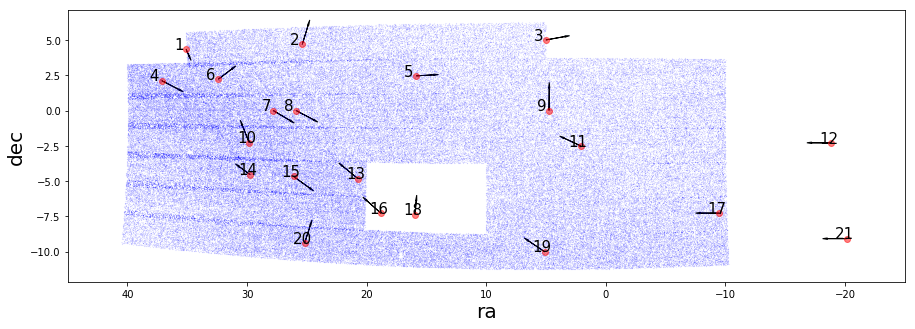

In [5]:
streamCenters = {"mu" : [], "r" : [], "lbr" : [], "radec" : [], 'ra' : [], 'dec' : [], 'theta' : [], 'phi' : [], 'wedge' : []}
wedgeCounter = 80

for i in fitParameters3:
    streamCenters["mu"].append(i[3])
    streamCenters["mu"].append(i[9])
    streamCenters["mu"].append(i[15])
    streamCenters["r"].append(i[4])
    streamCenters["r"].append(i[10])
    streamCenters["r"].append(i[16])
    streamCenters["lbr"].append(ac.GC2lbr(i[3], 0.0, i[4], wedgeCounter))
    streamCenters["lbr"].append(ac.GC2lbr(i[9], 0.0, i[10], wedgeCounter))
    streamCenters["lbr"].append(ac.GC2lbr(i[15], 0.0, i[16], wedgeCounter))
    streamCenters["radec"].append(ac.GCToEq(i[3], 0.0, wedgeCounter))
    streamCenters["radec"].append(ac.GCToEq(i[9], 0.0, wedgeCounter))
    streamCenters["radec"].append(ac.GCToEq(i[15], 0.0, wedgeCounter))
    streamCenters["ra"].append(ac.GCToEq(i[3], 0.0, wedgeCounter)[0])
    streamCenters["ra"].append(ac.GCToEq(i[9], 0.0, wedgeCounter)[0])
    streamCenters["ra"].append(ac.GCToEq(i[15], 0.0, wedgeCounter)[0])
    streamCenters["dec"].append(ac.GCToEq(i[3], 0.0, wedgeCounter)[1])
    streamCenters["dec"].append(ac.GCToEq(i[9], 0.0, wedgeCounter)[1])
    streamCenters["dec"].append(ac.GCToEq(i[15], 0.0, wedgeCounter)[1])
    streamCenters["theta"].append(i[5])
    streamCenters["theta"].append(i[11])
    streamCenters["theta"].append(i[17])
    streamCenters["phi"].append(i[6])
    streamCenters["phi"].append(i[12])
    streamCenters["phi"].append(i[18])
    streamCenters["wedge"].append(wedgeCounter)
    streamCenters["wedge"].append(wedgeCounter)
    streamCenters["wedge"].append(wedgeCounter)
    wedgeCounter+=1
    
streamCenters["lbr"] = np.array(streamCenters["lbr"], dtype=[("l",float),("b",float),("r",float)])
streamCenters["radec"] = np.array(streamCenters["radec"], dtype=[("ra",float),("dec",float)])


c = SkyCoord(stars[0], stars[1], frame='galactic', unit='deg').transform_to('icrs')
correctedRA = []
for i in c.ra:
#    print(i * u.deg)
    if i > 100 * u.deg:
        correctedRA.append((i - 360*u.deg).deg)
    else:
        correctedRA.append(i.deg)
for i in range(len(streamCenters["radec"]["ra"])):
    if streamCenters["radec"]["ra"][i] > 100:
        streamCenters["radec"]["ra"][i] -= 360
        streamCenters["ra"][i] -= 360

plt.figure(1,figsize=(15,5))
plt.plot(correctedRA, c.dec.deg, "bo", ms=.05, alpha=.5)
#plt.plot(clusters[0], clusters[1], "go")
plt.plot(streamCenters["radec"]['ra'], streamCenters["radec"]['dec'], 'ro',  alpha=.5)
makeArrows(streamCenters, 'dec')
plt.xlabel("ra", fontsize=20)
plt.ylabel("dec", fontsize=20)
plt.xlim([45,-25])
name = list(map(str, range(1,len(streamCenters['r'])+1)))
for i in range(len(name)):
    plt.text(streamCenters["radec"]['ra'][i]+1, streamCenters["radec"]['dec'][i], name[i], fontsize = 15)
    
plt.show()

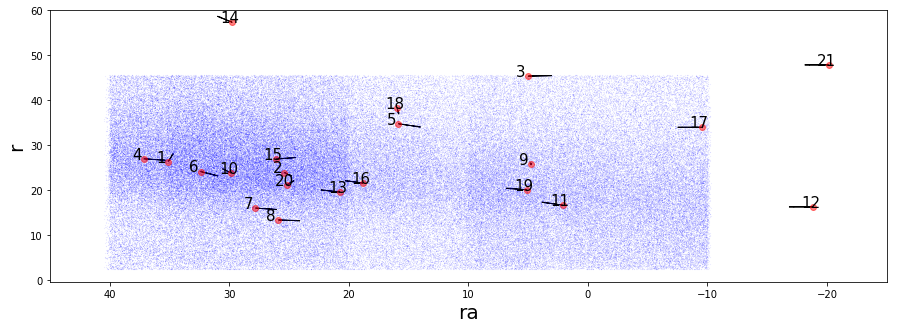

In [7]:
plt.figure(1,figsize=(15,5))
plt.plot(correctedRA, stars[2], "bo", ms=.05, alpha=.5)
#plt.plot(clusters[0], clusters[2], "go")
plt.plot(streamCenters["radec"]['ra'], streamCenters["lbr"]['r'], 'ro',  alpha=.5)
plt.xlabel("ra", fontsize=20)
plt.ylabel("r", fontsize=20)
makeArrows(streamCenters, 'r')
plt.xlim([45,-25])
for i in range(len(name)):
    plt.text(streamCenters["radec"]['ra'][i]+1, streamCenters["lbr"]['r'][i], name[i], fontsize = 15)
plt.show()